# NeuralTreeNet et ONNX

La conversion d'un arbre de décision au format ONNX peut créer des différences entre le modèle original et le modèle converti (voir [Issues when switching to float](http://www.xavierdupre.fr/app/onnxcustom/helpsphinx/gyexamples/plot_ebegin_float_double.html). Le problème vient d'un changement de type, les seuils de décisions sont arrondis au float32 le plus proche de leur valeur en float64 (double). Qu'advient-il si l'arbre de décision est converti en réseau de neurones d'abord.

L'approximation des seuils de décision ne change pas grand chose dans la majorité des cas. Cependant, il est possible que la comparaison d'une variable à un seuil de décision arrondi soit l'opposé de celle avec le seuil non arrondi. Dans ce cas, la décision suit un chemin différent dans l'arbre.

In [1]:
from jyquickhelper import add_notebook_menu

add_notebook_menu()

In [2]:
%matplotlib inline

In [3]:
%load_ext mlprodict

## Jeu de données

On construit un jeu de donnée aléatoire.

In [4]:
import numpy

X = numpy.random.randn(10000, 10)
y = X.sum(axis=1) / X.shape[1]
X = X.astype(numpy.float64)
y = y.astype(numpy.float64)

In [5]:
middle = X.shape[0] // 2
X_train, X_test = X[:middle], X[middle:]
y_train, y_test = y[:middle], y[middle:]

## Partie scikit-learn

### Caler un arbre de décision

In [6]:
from sklearn.tree import DecisionTreeRegressor

tree = DecisionTreeRegressor(max_depth=7)
tree.fit(X_train, y_train)
tree.score(X_train, y_train), tree.score(X_test, y_test)

(0.6179766027481131, 0.33709933420465643)

In [7]:
from sklearn.metrics import r2_score

r2_score(y_test, tree.predict(X_test))

0.33709933420465643

La profondeur de l'arbre est insuffisante mais ce n'est pas ce qui nous intéresse ici.

### Conversion au format ONNX

In [8]:
from skl2onnx import to_onnx

onx = to_onnx(tree, X[:1].astype(numpy.float32))

In [9]:
from onnxruntime import InferenceSession

x_exp = X_test

oinf = InferenceSession(onx.SerializeToString())
expected = tree.predict(x_exp)

got = oinf.run({"X": x_exp.astype(numpy.float32)})[0]
numpy.abs(got - expected).max()

1.7421041873949668

In [10]:
from onnx_array_api.plotting.text_plot import onnx_simple_text_plot

print(onnx_simple_text_plot(onx))

opset: domain='ai.onnx.ml' version=1
opset: domain='' version=15
input: name='X' type=dtype('float32') shape=[None, 10]
TreeEnsembleRegressor(X, n_targets=1, nodes_falsenodeids=253:[128,65,34...252,0,0], nodes_featureids=253:[8,3,9...2,0,0], nodes_hitrates=253:[1.0,1.0...1.0,1.0], nodes_missing_value_tracks_true=253:[0,0,0...0,0,0], nodes_modes=253:[b'BRANCH_LEQ',b'BRANCH_LEQ'...b'LEAF',b'LEAF'], nodes_nodeids=253:[0,1,2...250,251,252], nodes_treeids=253:[0,0,0...0,0,0], nodes_truenodeids=253:[1,2,3...251,0,0], nodes_values=253:[0.00792999193072319,-0.12246682494878769...0.0,0.0], post_transform=b'NONE', target_ids=127:[0,0,0...0,0,0], target_nodeids=127:[7,8,10...249,251,252], target_treeids=127:[0,0,0...0,0,0], target_weights=127:[-0.9345570802688599,-0.6372960805892944...0.6169403195381165,1.0096807479858398]) -> variable
output: name='variable' type=dtype('float32') shape=[None, 1]


## Après la conversion en un réseau de neurones

### Conversion en un réseau de neurones

Un paramètre permet de faire varier la pente des fonctions sigmoïdes utilisées.

In [11]:
from tqdm import tqdm
from pandas import DataFrame
from mlstatpy.ml.neural_tree import NeuralTreeNet

xe = x_exp[:500]
expected = tree.predict(xe)

data = []
trees = {}
for i in tqdm([0.3, 0.4, 0.5, 0.7, 0.9, 1] + list(range(5, 61, 5))):
    root = NeuralTreeNet.create_from_tree(tree, k=i, arch="compact")
    got = root.predict(xe)[:, -1]
    me = numpy.abs(got - expected).mean()
    mx = numpy.abs(got - expected).max()
    obs = dict(k=i, max=mx, mean=me)
    data.append(obs)
    trees[i] = root

100%|██████████| 18/18 [00:01<00:00, 12.49it/s]


In [12]:
df = DataFrame(data)
df

,k,max,mean
0,0.3,0.568981,0.158758
1,0.4,0.608304,0.132576
2,0.5,0.692657,0.128525
3,0.7,0.780543,0.131497
4,0.9,0.809866,0.128368
5,1.0,0.813889,0.124802
6,5.0,0.392482,0.022466
7,10.0,0.341749,0.006350
8,15.0,0.270649,0.002939
9,20.0,0.299713,0.002110


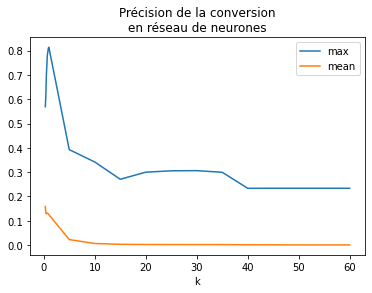

In [13]:
df.set_index("k").plot(title="Précision de la conversion\nen réseau de neurones");

L'erreur est meilleure mais il faudrait recommencer l'expérience plusieurs fois avant de pouvoir conclure afin d'obtenir un interval de confiance pour le même type de jeu de données. Ce sera pour une autre fois. Le résultat dépend du jeu de données et surtout de la proximité des seuils de décisions. Néanmoins, on calcule l'erreur sur l'ensemble de la base de test. Celle-ci a été tronquée pour aller plus vite.

In [14]:
expected = tree.predict(x_exp)
got = trees[50].predict(x_exp)[:, -1]
numpy.abs(got - expected).max(), numpy.abs(got - expected).mean()

(0.2336143002078063, 0.0002511855017989173)

On voit que l'erreur peut-être très grande. Elle reste néanmoins plus petite que l'erreur de conversion introduite par ONNX.

### Conversion au format ONNX

On crée tout d'abord une classe qui suit l'API de scikit-learn et qui englobe l'arbre qui vient d'être créé qui sera ensuite convertit en ONNX.

In [15]:
from mlstatpy.ml.neural_tree import NeuralTreeNetRegressor

reg = NeuralTreeNetRegressor(trees[50])
onx2 = to_onnx(reg, X[:1].astype(numpy.float32))

In [16]:
print(onnx_simple_text_plot(onx2))

opset: domain='' version=15
input: name='X' type=dtype('float32') shape=[None, 10]
init: name='Ma_MatMulcst' type=dtype('float32') shape=(1260,)
init: name='Ad_Addcst' type=dtype('float32') shape=(126,)
init: name='Mu_Mulcst' type=dtype('float32') shape=(1,) -- array([4.], dtype=float32)
init: name='Ma_MatMulcst1' type=dtype('float32') shape=(16002,)
init: name='Ad_Addcst1' type=dtype('float32') shape=(127,)
init: name='Ma_MatMulcst2' type=dtype('float32') shape=(127,)
init: name='Ad_Addcst2' type=dtype('float32') shape=(1,) -- array([0.], dtype=float32)
MatMul(X, Ma_MatMulcst) -> Ma_Y02
  Add(Ma_Y02, Ad_Addcst) -> Ad_C02
    Mul(Ad_C02, Mu_Mulcst) -> Mu_C01
      Sigmoid(Mu_C01) -> Si_Y01
        MatMul(Si_Y01, Ma_MatMulcst1) -> Ma_Y01
          Add(Ma_Y01, Ad_Addcst1) -> Ad_C01
            Mul(Ad_C01, Mu_Mulcst) -> Mu_C0
              Sigmoid(Mu_C0) -> Si_Y0
                MatMul(Si_Y0, Ma_MatMulcst2) -> Ma_Y0
                  Add(Ma_Y0, Ad_Addcst2) -> Ad_C0
                    Ide

In [17]:
oinf2 = OnnxInference(onx2, runtime="onnxruntime1")
expected = tree.predict(x_exp)

got = oinf2.run({"X": x_exp.astype(numpy.float32)})["variable"]
numpy.abs(got - expected).max()

1.7421041873949668

L'erreur est la même.

## Temps de calcul

In [18]:
x_exp32 = x_exp.astype(numpy.float32)

Tout d'abord le temps de calcul pour scikit-learn.

In [19]:
%timeit tree.predict(x_exp32)

513 µs ± 7.52 µs per loop (mean ± std. dev. of 7 runs, 1,000 loops each)


Le temps de calcul pour l'arbre de décision au format ONNX.

In [20]:
%timeit oinf.run({'X': x_exp32})['variable']

186 µs ± 3.41 µs per loop (mean ± std. dev. of 7 runs, 10,000 loops each)


Et le temps de calcul pour le réseau de neurones au format ONNX.m

In [21]:
%timeit oinf2.run({'X': x_exp32})['variable']

3.75 ms ± 311 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


Ce temps de calcul très long est attendu car le modèle contient une multiplication de matrice très grande et surtout que tous les seuils de l'arbre sont calculés pour chaque observation. Là où l'implémentation de l'arbre de décision calcule *d* seuils, la profondeur de l'arbre, la nouvelle implémentation calcule tous les seuils soit $2^d$ pour chaque feuille. Il y a $2^d$ feuilles. Même en étant sparse, on peut réduire les calculs à $d * 2^d$ ce qui fait encore beaucoup de calculs inutiles.

In [22]:
for node in trees[50].nodes:
    print(node.coef.shape, node.bias.shape)

(126, 11) (126,)
(127, 127) (127,)
(128,) ()


Cela dit, la plus grande matrice est creuse, elle peut être réduite considérablement.

In [23]:
from scipy.sparse import csr_matrix

for node in trees[50].nodes:
    csr = csr_matrix(node.coef)
    print(
        f"coef.shape={node.coef.shape}, size dense={node.coef.size}, "
        f"size sparse={csr.size}, ratio={csr.size / node.coef.size}"
    )

coef.shape=(126, 11), size dense=1386, size sparse=252, ratio=0.18181818181818182
coef.shape=(127, 127), size dense=16129, size sparse=1015, ratio=0.06293012586025172
coef.shape=(128,), size dense=128, size sparse=127, ratio=0.9921875


In [24]:
r = numpy.random.randn(trees[50].nodes[1].coef.shape[0])
mat = trees[50].nodes[1].coef
%timeit mat @ r

49.8 µs ± 1.25 µs per loop (mean ± std. dev. of 7 runs, 10,000 loops each)


In [25]:
csr = csr_matrix(mat)
%timeit csr @ r

7.08 µs ± 173 ns per loop (mean ± std. dev. of 7 runs, 100,000 loops each)


Ce serait beaucoup plus rapide avec une matrice sparse et d'autant plus rapide que l'arbre est profond. Le modèle ONNX se décompose comme suit.

In [26]:
print(onnx_simple_text_plot(onx2))

opset: domain='' version=15
input: name='X' type=dtype('float32') shape=[None, 10]
init: name='Ma_MatMulcst' type=dtype('float32') shape=(1260,)
init: name='Ad_Addcst' type=dtype('float32') shape=(126,)
init: name='Mu_Mulcst' type=dtype('float32') shape=(1,) -- array([4.], dtype=float32)
init: name='Ma_MatMulcst1' type=dtype('float32') shape=(16002,)
init: name='Ad_Addcst1' type=dtype('float32') shape=(127,)
init: name='Ma_MatMulcst2' type=dtype('float32') shape=(127,)
init: name='Ad_Addcst2' type=dtype('float32') shape=(1,) -- array([0.], dtype=float32)
MatMul(X, Ma_MatMulcst) -> Ma_Y02
  Add(Ma_Y02, Ad_Addcst) -> Ad_C02
    Mul(Ad_C02, Mu_Mulcst) -> Mu_C01
      Sigmoid(Mu_C01) -> Si_Y01
        MatMul(Si_Y01, Ma_MatMulcst1) -> Ma_Y01
          Add(Ma_Y01, Ad_Addcst1) -> Ad_C01
            Mul(Ad_C01, Mu_Mulcst) -> Mu_C0
              Sigmoid(Mu_C0) -> Si_Y0
                MatMul(Si_Y0, Ma_MatMulcst2) -> Ma_Y0
                  Add(Ma_Y0, Ad_Addcst2) -> Ad_C0
                    Ide

Voyons comment le temps de calcul se répartit.

In [27]:
oinfpr = OnnxInference(
    onx2, runtime="onnxruntime1", runtime_options={"enable_profiling": True}
)
for i in range(0, 43):
    oinfpr.run({"X": x_exp32})

In [28]:
df = oinfpr.get_profiling(as_df=True)
df

,cat,pid,tid,dur,ts,ph,name,args_op_name,args_parameter_size,args_graph_index,args_provider,args_exec_plan_index,args_activation_size,args_output_size,args_input_type_shape,args_output_type_shape,args_thread_scheduling_stats
0,Session,78116,8820,387,4,X,model_loading_array,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,Session,78116,8820,2532,428,X,session_initialization,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,Node,78116,8820,0,3294,X,gemm_fence_before,Gemm,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,Node,78116,8820,1315,3300,X,gemm_kernel_time,Gemm,5544,11,CPUExecutionProvider,11,200000,2520000,"[{'float': [5000, 10]}, {'float': [10, 126]}, ...","[{'float': [5000, 126]}]",{'main_thread': {'thread_pool_name': 'session-...
4,Node,78116,8820,0,4635,X,gemm_fence_after,Gemm,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
986,Node,78116,8820,0,210170,X,Ma_MatMul2_fence_before,MatMul,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
987,Node,78116,8820,124,210172,X,Ma_MatMul2_kernel_time,MatMul,508,8,CPUExecutionProvider,8,2540000,20000,"[{'float': [5000, 127]}, {'float': [127, 1]}]","[{'float': [5000, 1]}]",{'main_thread': {'thread_pool_name': 'session-...
988,Node,78116,8820,0,210305,X,Ma_MatMul2_fence_after,MatMul,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
989,Session,78116,8820,4378,205930,X,SequentialExecutor::Execute,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [29]:
set(df["args_provider"])

{'CPUExecutionProvider', nan}

In [30]:
dfp = df[df.args_provider == "CPUExecutionProvider"].copy()
dfp["name"] = dfp["name"].apply(lambda s: s.replace("_kernel_time", ""))
gr_dur = (
    dfp[["dur", "args_op_name", "name"]]
    .groupby(["args_op_name", "name"])
    .sum()
    .sort_values("dur")
)
gr_dur

dur
args_op_name name               
MatMul       Ma_MatMul2     6778
Mul          Mu_Mul        12923
Sigmoid      Si_Sigmoid    14849
Mul          Mu_Mul1       15151
Sigmoid      Si_Sigmoid1   15608
Gemm         gemm          31763
             gemm_token_0  99047

In [31]:
gr_n = (
    dfp[["dur", "args_op_name", "name"]]
    .groupby(["args_op_name", "name"])
    .count()
    .sort_values("dur")
)
gr_n = gr_n.loc[gr_dur.index, :]
gr_n

dur
args_op_name name             
MatMul       Ma_MatMul2     43
Mul          Mu_Mul         43
Sigmoid      Si_Sigmoid     43
Mul          Mu_Mul1        43
Sigmoid      Si_Sigmoid1    43
Gemm         gemm           43
             gemm_token_0   43

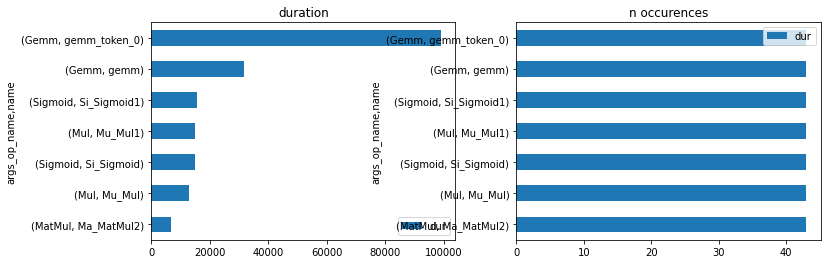

In [32]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(1, 2, figsize=(12, 4))
gr_dur.plot.barh(ax=ax[0])
gr_n.plot.barh(ax=ax[1])
ax[0].set_title("duration")
ax[1].set_title("n occurences");

onnxruntime passe principalement son temps dans un produit matriciel. On vérifie plus précisément.

In [33]:
df[(df.args_op_name == "Gemm") & (df.dur > 0)].sort_values("dur", ascending=False).head(
    n=2
).T

,127,12
cat,Node,Node
pid,78116,78116
tid,8820,8820
dur,4603,4083
ts,37173,5949
ph,X,X
name,gemm_token_0_kernel_time,gemm_token_0_kernel_time
args_op_name,Gemm,Gemm
args_parameter_size,64516,64516
args_graph_index,12,12


C'est un produit matriciel d'environ *5000x800* par *800x800*.

In [34]:
gr_dur / gr_dur.dur.sum()

dur
args_op_name name                  
MatMul       Ma_MatMul2    0.034561
Mul          Mu_Mul        0.065894
Sigmoid      Si_Sigmoid    0.075714
Mul          Mu_Mul1       0.077254
Sigmoid      Si_Sigmoid1   0.079584
Gemm         gemm          0.161958
             gemm_token_0  0.505035

In [35]:
r = (gr_dur / gr_dur.dur.sum()).dur.max()
r

0.5050352082154203

Il occupe 82% du temps. et d'après l'expérience précédente, son temps d'éxecution peut-être réduit par 10 en le remplaçant par une matrice sparse. Cela ne suffira pas pour accélerer le temps de calcul de ce réseau de neurones. Il est 84 ms comparé à 247 µs pour l'arbre de décision. Avec cette optimisation, il pourrait passer de :

In [36]:
t = 3.75  # ms
t * (1 - r) + r * t / 12

2.013941471759493

Soit une réduction du temps de calcul. Ce n'est pas mal mais pas assez.

## Hummingbird

[hummingbird](https://github.com/microsoft/hummingbird) est une librairie qui convertit un arbre de décision en réseau de neurones. Voyons ses performances.

In [37]:
from hummingbird.ml import convert

model = convert(tree, "torch")

expected = tree.predict(x_exp)
got = model.predict(x_exp)
numpy.abs(got - expected).max(), numpy.abs(got - expected).mean()

C:\xavierdupre\__home_\github_fork\scikit-learn\sklearn\utils\deprecation.py:103: FutureWarning: The attribute `n_features_` is deprecated in 1.0 and will be removed in 1.2. Use `n_features_in_` instead.
  warnings.warn(msg, category=FutureWarning)


(4.3419181139370266e-08, 4.430287026515114e-09)

Le résultat est beaucoup plus fidèle au modèle.

In [38]:
%timeit model.predict(x_exp)

1.17 ms ± 34.8 µs per loop (mean ± std. dev. of 7 runs, 1,000 loops each)


Il reste plus lent mais beaucoup plus rapide que la solution manuelle proposée dans les précédents paragraphes. Il contient un attribut `model`.

In [39]:
from torch.nn import Module

isinstance(model.model, Module)

True

On convertit ce modèle au format ONNX.

In [40]:
import torch.onnx

x = torch.randn(x_exp.shape[0], x_exp.shape[1], requires_grad=True)
torch.onnx.export(
    model.model,
    x,
    "tree_torch.onnx",
    opset_version=15,
    input_names=["X"],
    output_names=["variable"],
    dynamic_axes={"X": {0: "batch_size"}, "variable": {0: "batch_size"}},
)

In [41]:
import onnx

onxh = onnx.load("tree_torch.onnx")

In [42]:
print(onnx_simple_text_plot(onxh, raise_exc=False))

opset: domain='' version=15
input: name='X' type=dtype('float32') shape=['batch_size', 10]
init: name='_operators.0.root_nodes' type=dtype('int64') shape=(0,) -- array([8], dtype=int64)
init: name='_operators.0.root_biases' type=dtype('float32') shape=(0,) -- array([0.00792999], dtype=float32)
init: name='_operators.0.tree_indices' type=dtype('int64') shape=(0,) -- array([0], dtype=int64)
init: name='_operators.0.leaf_nodes' type=dtype('float32') shape=(0,) -- array([ 1.0096807 ,  0.6169403 ,  0.61055773,  0.37810475,  0.31796893,
        0.13317925,  0.0193846 , -0.2317742 ,  0.39089343,  0.23506087,
        0.3711936 ,  0.10317916,  0.14956598, -0.14193445, -0.05965868,
       -0.27377078,  0.4128183 ,  0.19658326,  0.25545415,  0.08118545,
        0.08400188, -0.1502193 , -0.36846825, -0.79687625,  0.35822242,
        0.49021915,  0.30870998,  0.01033915,  0.6740977 ,  0.6740977 ,
       -0.15315758, -0.41128033,  0.42920846,  0.13145493,  0.21853392,
       -0.10986731,  0.4493652 

output: name='variable' type=dtype('float32') shape=['batch_size', 'ReduceSumvariable_dim_1']


In [43]:
%onnxview onxh

La librairie réimplémente la décision d'un arbre décision à partir d'un produit matriciel pour chaque niveau de l'arbre. Tous les seuils sont évalués. Les matrices n'ont pas besoin d'être sparses car les features nécessaires sont récupérées. Le seuil de décision est implémenté avec un test et non une sigmoïde. Ce modèle est donc identique en terme de prédiction au modèle initial.

In [44]:
oinfh = OnnxInference(onxh, runtime="onnxruntime1")
expected = tree.predict(x_exp)

got = oinfh.run({"X": x_exp.astype(numpy.float32)})["variable"]
numpy.abs(got - expected).max()

1.7421041873949668

La conversion reste imparfaite également.

In [45]:
%timeit oinfh.run({'X': x_exp32})['variable']

3.13 ms ± 445 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


Et le temps de calcul est aussi plus long.

## Apprentissage

L'idée derrière tout cela est aussi de pouvoir réestimer les coefficients du réseau de neurones une fois converti.

In [46]:
x_train = X_train[:100]
expected = tree.predict(x_train)
reg = NeuralTreeNetRegressor(trees[1], verbose=1, max_iter=10, lr=1e-4)

In [47]:
got = reg.predict(x_train)
numpy.abs(got - expected).max(), numpy.abs(got - expected).mean()

(1.0246115055833722, 0.24094382754240642)

La différence est grande.

In [48]:
reg.fit(x_train, expected)

0/10: loss: 3.201 lr=0.0001 max(coef): 6.5 l1=0/1.5e+03 l2=0/2.5e+03
1/10: loss: 2.593 lr=9.95e-06 max(coef): 6.5 l1=2e+03/1.5e+03 l2=1.3e+03/2.5e+03
2/10: loss: 2.506 lr=7.05e-06 max(coef): 6.5 l1=1.4e+02/1.5e+03 l2=6.2/2.5e+03
3/10: loss: 2.461 lr=5.76e-06 max(coef): 6.5 l1=1.2e+03/1.5e+03 l2=6.8e+02/2.5e+03
4/10: loss: 2.429 lr=4.99e-06 max(coef): 6.5 l1=6.5e+02/1.5e+03 l2=2.1e+02/2.5e+03
5/10: loss: 2.405 lr=4.47e-06 max(coef): 6.5 l1=1.9e+02/1.5e+03 l2=13/2.5e+03
6/10: loss: 2.392 lr=4.08e-06 max(coef): 6.5 l1=1.6e+02/1.5e+03 l2=6.8/2.5e+03
7/10: loss: 2.375 lr=3.78e-06 max(coef): 6.5 l1=1.8e+02/1.5e+03 l2=9.5/2.5e+03
8/10: loss: 2.358 lr=3.53e-06 max(coef): 6.5 l1=1.1e+02/1.5e+03 l2=7/2.5e+03
9/10: loss: 2.345 lr=3.33e-06 max(coef): 6.5 l1=3.7e+02/1.5e+03 l2=56/2.5e+03
10/10: loss: 2.333 lr=3.16e-06 max(coef): 6.5 l1=6.1e+02/1.5e+03 l2=1.3e+02/2.5e+03


NeuralTreeNetRegressor(estimator=None, lr=0.0001, max_iter=10, verbose=1)

In [49]:
got = reg.predict(x_train)
numpy.abs(got - expected).max(), numpy.abs(got - expected).mean()

(1.256860512819292, 0.25663312220721907)

Ca ne marche pas aussi bien que prévu. Il faudrait sans doute plusieurs itérations et jouer avec les paramètres d'apprentissage.